Phase 1:
predicting a wave source location using a CNN.

1. Generate data for this model:

In [27]:
#imports:
import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from scipy import signal
from torch.utils.data import random_split

1. Generating Physics Data...
2. Converting Coordinates to Heatmaps...
DONE! Input X: torch.Size([5000, 4, 200]), Target Y: torch.Size([5000, 1, 32, 32])


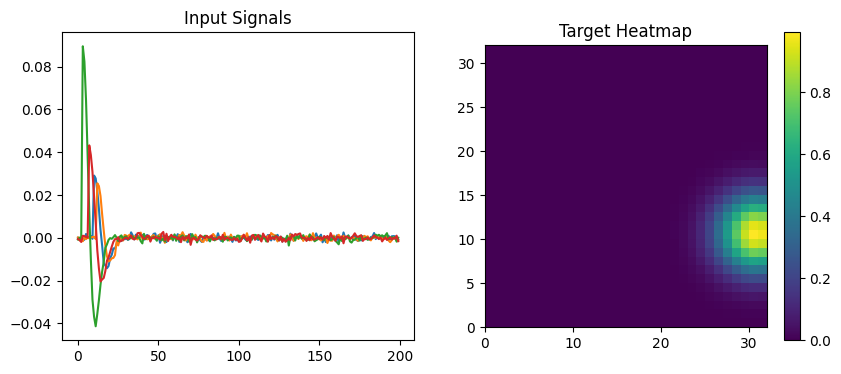

In [28]:

# --- 1. The Physics Simulator (Generates X and x,y coords) ---
def generate_seismic_data(num_samples=5000, grid_size=32, velocity=300, noise_level=0.001, num_sensors=4, time_steps=200):
    """
    Generates synthetic wave propagation data.
    """
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size) # Make sure grid size matches physical size for simplicity

    # Sensors at corners
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # Random Sources
    source_locs = np.random.rand(num_samples, 2) * [x_max, y_max]

    # Calculate Distances
    diff = source_locs[:, np.newaxis, :] - sensor_locs[np.newaxis, :, :]
    distances = np.sqrt(np.sum(diff**2, axis=2))

    # Generate Ricker Wavelet
    t = np.arange(time_steps) * dt
    f0 = 5.0
    wavelet = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet = wavelet / np.max(np.abs(wavelet))

    # Simulate Waves
    X_data = np.zeros((num_samples, num_sensors, time_steps))
    for i in range(num_samples):
        for s in range(num_sensors):
            dist = distances[i, s]
            arrival_time = dist / velocity
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            if shift_steps < time_steps:
                valid_len = time_steps - shift_steps
                X_data[i, s, shift_steps:] = wavelet[:valid_len] * amplitude

    # Add Noise
    noise = np.random.normal(0, noise_level, X_data.shape)
    X_data += noise

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(source_locs, dtype=torch.float32)

# --- 2. The Heatmap Converter (Turns x,y coords into Images) ---
def create_gaussian_map(coords, grid_size, sigma=3.0):
    x = np.arange(grid_size)
    y = np.arange(grid_size)
    xx, yy = np.meshgrid(x, y)
    maps = []

    for (cx, cy) in coords:
        # Gaussian formula
        gauss = np.exp(-((xx - cx)**2 + (yy - cy)**2) / (2 * sigma**2))
        maps.append(gauss)

    return np.array(maps)

# --- 3. Execute Generation ---
print("1. Generating Physics Data...")
# Note: grid_size=32 to match your model output
X_raw, coords_raw = generate_seismic_data(num_samples=5000, grid_size=32, velocity=300, noise_level=0.001)

print("2. Converting Coordinates to Heatmaps...")
Y_heatmaps = create_gaussian_map(coords_raw.numpy(), grid_size=32, sigma=3.0)
Y_grid = torch.tensor(Y_heatmaps, dtype=torch.float32).unsqueeze(1) # Add channel dim: [5000, 1, 32, 32]

print(f"DONE! Input X: {X_raw.shape}, Target Y: {Y_grid.shape}")

# --- 4. Visualize to Verify ---
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for s in range(4):
    plt.plot(X_raw[0, s, :])
plt.title("Input Signals")

plt.subplot(1, 2, 2)
plt.imshow(Y_grid[0, 0], origin='lower', extent=[0,32,0,32])
plt.title("Target Heatmap")
plt.colorbar()
plt.show()

As we can see in the printed plot, the amplitude's values are relatively small. In order to prevent vanishing gradient problems we will pre-process the data by normalizing it.
Since the relativity between different measurment is important, we will use max-scaling (divide by the global maximal value).
We will also split the data into 80% training set, 10% validation set and 10% test set.

In [33]:
# --- 1. Split Raw Tensors Manually ---
# We do this instead of random_split so we can access X_train for normalization
N = len(X_raw)
indices = torch.randperm(N)

# Define counts
n_train = int(0.8 * N)
n_val = int(0.1 * N)
n_test = N - n_train - n_val

# Slice the indices
train_idx = indices[:n_train]
val_idx   = indices[n_train : n_train + n_val]
test_idx  = indices[n_train + n_val :]

# Create the split tensors
X_train, Y_train = X_raw[train_idx], Y_grid[train_idx]
X_val,   Y_val   = X_raw[val_idx],   Y_grid[val_idx]
X_test,  Y_test  = X_raw[test_idx],  Y_grid[test_idx]

# --- 2. Calculate Normalization Factor (The "Ruler") ---
# IMPORTANT: Calculate max only on Training data
norm_factor = torch.max(torch.abs(X_train))
print(f"Normalization Factor (Train Max): {norm_factor:.6f}")

# --- 3. Apply Normalization ---
X_train = X_train / norm_factor
X_val   = X_val   / norm_factor
X_test  = X_test  / norm_factor

# --- 4. Create DataLoaders ---
# Now we wrap the normalized tensors into DataLoaders
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, Y_val),   batch_size=64, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, Y_test),  batch_size=64, shuffle=False)

print(f"Data ready: {len(train_loader.dataset)} Train, {len(val_loader.dataset)} Val, {len(test_loader.dataset)} Test")

Normalization Factor (Train Max): 0.828137
Data ready: 4000 Train, 500 Val, 500 Test


We generate "hard" test set.
It is a test set that has slightly different velocity and more noise than the date we generated before.
After generating it we will also normalize it.
We will use this test set after the "regular" test set to prove that our mode is robust to different inputs.

In [48]:
#generating "hard" test set:
X_hard_raw, Y_hard = generate_seismic_data(num_samples=1000, velocity=315, noise_level=0.01)
X_hard = X_hard_raw / norm_factor  # Re-use the training "ruler"
test_hard_loader = DataLoader(TensorDataset(X_hard, Y_hard), batch_size=64, shuffle=False)

The networks architecture:
The architecture is divided into a encoder-decoder structure.
The first part is the encoder which contains 3 blocks of 1d conv, batch norm and ReLu. It recieves a high dimensional input and decrease it to a smaller dimensional output. The input is time propagation of a wave amplitude so we chose 1d conv that will "slide" along the time axis only.
The down sampling in this part allows the network to learn time trends instead of looking at each time step seperatly.
The bridge is the fully connceted layer between the encoder and the decoder. It connects each "time pixel" to "location pixel" in the network's output map.
The decoder contains 2 blocks of 2d transposed convulotion, batch norm and ReLu, an other 2d conv and a sigmoid at the end.
We use ReLu in order to prevent vanishing gradients, Sigmoid because our it limites each pixel in the output map to have a valid probability value and batch norm to make the model more stable.

In [35]:
class WaveToMapNet(nn.Module):
    def __init__(self):
        super(WaveToMapNet, self).__init__()

        # --- PART 1: THE ENCODER (The "Ear") ---
        # Input: [Batch, 4 sensors, 200 time_steps]
        # Goal: Compress time signals into rich features
        self.encoder = nn.Sequential(
            # Layer 1: Detect basic edges/slopes
            nn.Conv1d(in_channels=4, out_channels=32, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            # Layer 2: Detect wave shapes (pulses)
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            # Layer 3: Detect complex patterns (e.g. time delays between channels)
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        # --- PART 2: THE BRIDGE (The "Translator") ---
        # Goal: Convert Time info into Spatial info
        # Calculation: Input 200 -> stride 2 (100) -> stride 2 (50) -> stride 2 (25)
        # Final shape: 128 channels * 25 time steps = 3200 features
        self.fc = nn.Linear(3200, 64 * 8 * 8) # Output: 4096 features

        # --- PART 3: THE DECODER (The "Artist") ---
        # Goal: Paint a 32x32 image from the features
        self.decoder = nn.Sequential(
            # Input starts as a 8x8 square with 64 channels

            # Upsample 1: 8x8 -> 16x16
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            # Upsample 2: 16x16 -> 32x32
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            # Final Polish: Reduce to 1 channel (Heatmap)
            nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),

            # Output Activation: Force values to be 0.0 to 1.0 (Probability)
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. Encode: Extract time features
        # x shape: [Batch, 4, 200]
        x = self.encoder(x)
        # x shape: [Batch, 128, 25]

        # 2. Bridge: Flatten and reshape
        x = x.view(x.size(0), -1)      # Flatten to [Batch, 3200]
        x = self.fc(x)                 # Transform to [Batch, 4096]
        x = x.view(x.size(0), 64, 8, 8)# Reshape to 3D Cube [Batch, 64, 8, 8]

        # 3. Decode: Generate Image
        x = self.decoder(x)
        # x shape: [Batch, 1, 32, 32]
        return x

Now we will train the model.
We chose Kaiming initialization since we worked with ReLu activation.
20 epochs and Adam optimizer.
Our loss function is the MSE loss, since our output is a heatmap it forces each pixel in it to be as close as possible to the matching target pixel.



Training on: cpu
Starting Training...
Epoch 2/20 | Train Loss: 0.006421 | Val Loss: 0.004844
Epoch 4/20 | Train Loss: 0.002136 | Val Loss: 0.002327
Epoch 6/20 | Train Loss: 0.001056 | Val Loss: 0.003159
Epoch 8/20 | Train Loss: 0.000645 | Val Loss: 0.001791
Epoch 10/20 | Train Loss: 0.000421 | Val Loss: 0.001519
Epoch 12/20 | Train Loss: 0.000309 | Val Loss: 0.001342
Epoch 14/20 | Train Loss: 0.000237 | Val Loss: 0.001232
Epoch 16/20 | Train Loss: 0.000201 | Val Loss: 0.001342
Epoch 18/20 | Train Loss: 0.000184 | Val Loss: 0.001282
Epoch 20/20 | Train Loss: 0.000171 | Val Loss: 0.001147
Training Complete!


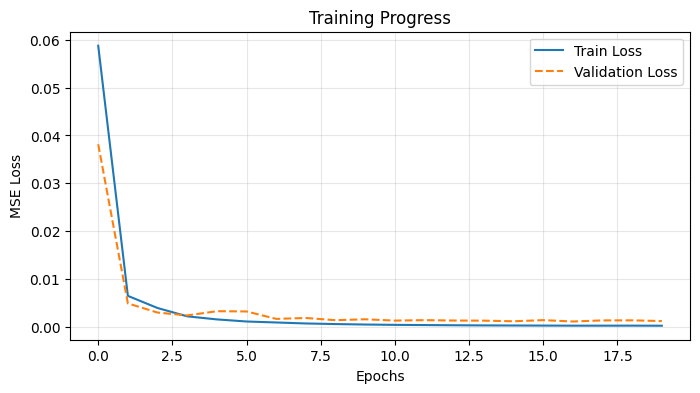

In [36]:

# --- 1. Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

# Initialize Model
model = WaveToMapNet().to(device)

# Optimizer: Adam is the standard for this type of problem
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Loss Function: MSE (Mean Squared Error)
# We use MSE because we want the pixel values of our prediction
# to match the pixel values of the ground truth heatmap.
criterion = nn.MSELoss()

# --- 2. Training Loop ---
epochs = 20
train_losses = []
val_losses = []

print("Starting Training...")

for epoch in range(epochs):
    # -- TRAIN PHASE --
    model.train()
    running_train_loss = 0.0

    for inputs, targets in train_loader:
        # Move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)

        # Backward pass
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    # -- VALIDATION PHASE --
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item()

    # -- LOGGING --
    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print progress every 2 epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

print("Training Complete!")

# --- 3. Plot Learning Curve ---
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.title("Training Progress")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

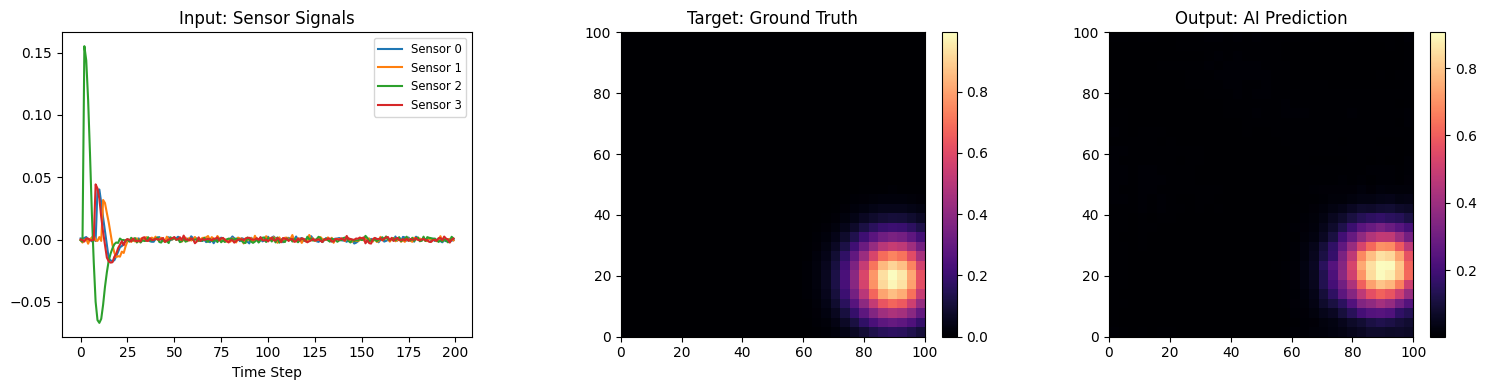

In [37]:
def visualize_result(model, loader):
    model.eval()

    # Get one batch from validation
    inputs, targets = next(iter(loader))
    inputs, targets = inputs.to(device), targets.to(device)

    # Predict
    with torch.no_grad():
        predictions = model(inputs)

    # Move to CPU for plotting
    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    predictions = predictions.cpu().numpy()

    # Pick a random sample from the batch
    idx = 0

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Plot 1: What the Sensors Heard (Input)
    for s in range(4):
        axes[0].plot(inputs[idx, s], label=f'Sensor {s}')
    axes[0].set_title("Input: Sensor Signals")
    axes[0].set_xlabel("Time Step")
    axes[0].legend(loc='upper right', fontsize='small')

    # Plot 2: Where the Source Actually Is (Ground Truth)
    im1 = axes[1].imshow(targets[idx, 0], origin='lower', extent=[0,100,0,100], cmap='magma')
    axes[1].set_title("Target: Ground Truth")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Plot 3: Where the AI Thinks it Is (Prediction)
    im2 = axes[2].imshow(predictions[idx, 0], origin='lower', extent=[0,100,0,100], cmap='magma')
    axes[2].set_title("Output: AI Prediction")
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Run it!
visualize_result(model, val_loader)

Now we will check our performance in the test set, and on the hard test set (which have different velocity and noise in order to check generalization).
Since we are predicting location, we will use the following helper function to find the brightest pixel in the output (the one that has highest probability) and then convert it to the location of it in space.

In [38]:
def get_location_from_heatmap(heatmap, grid_size=32, field_size=100.0):
    """
    Finds the (x, y) coordinates of the peak value in a heatmap.
    Returns coords in METERS.
    """
    # Flatten the heatmap to find the index of the max value
    flat_idx = torch.argmax(heatmap)

    # Convert flat index to 2D index (row, col)
    row = flat_idx // grid_size
    col = flat_idx % grid_size

    # Convert grid index to real-world meters
    # Note: row corresponds to y, col to x (depending on imshow origin, usually bottom-left)
    # We assume origin='lower' so row 0 is y=0
    pixel_size = field_size / grid_size
    x_meter = col.item() * pixel_size
    y_meter = row.item() * pixel_size

    return np.array([x_meter, y_meter])

def evaluate_model(model, loader, device, dataset_name="Test Set"):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # Iterate through the batch
            for i in range(len(inputs)):
                # Get True Location (from Target Heatmap)
                true_loc = get_location_from_heatmap(targets[i, 0])

                # Get Predicted Location (from Output Heatmap)
                pred_loc = get_location_from_heatmap(outputs[i, 0])

                # Calculate Euclidean Distance Error (in meters)
                dist = np.linalg.norm(true_loc - pred_loc)
                errors.append(dist)

    mean_error = np.mean(errors)
    median_error = np.median(errors)

    print(f"--- Results for {dataset_name} ---")
    print(f"Mean Error:   {mean_error:.2f} meters")
    print(f"Median Error: {median_error:.2f} meters")
    print(f"Max Error:    {np.max(errors):.2f} meters")

    return errors

print("Evaluation functions ready.")

Evaluation functions ready.


--- Results for Standard Test Set ---
Mean Error:   2.86 meters
Median Error: 3.12 meters
Max Error:    6.99 meters


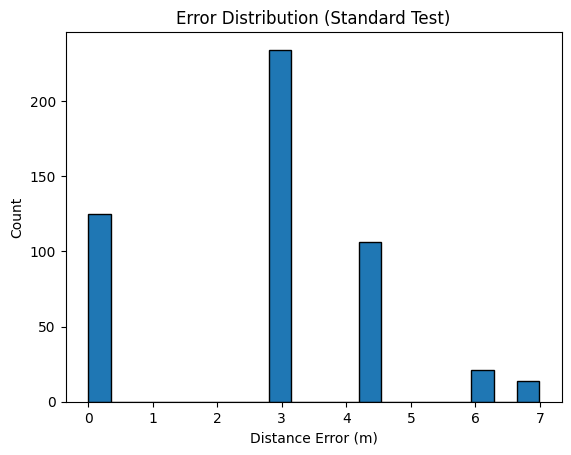

In [39]:
# Evaluate on Standard Test Set
std_errors = evaluate_model(model, test_loader, device, "Standard Test Set")

# Optional: Histogram of errors
plt.hist(std_errors, bins=20, edgecolor='black')
plt.title("Error Distribution (Standard Test)")
plt.xlabel("Distance Error (m)")
plt.ylabel("Count")
plt.show()

We achieved a Mean Error of 2.86 meters.
Our Field Size is 100X100 meters, The grid Size is 32X32 pixels, each pixel Resolution is 100 / 32 = 3.125 m/pixel.
Our error, 2.86m is smaller than a single pixel 3.125m.
Therfore, our model is statistically as accurate as it can possibly be given the low resolution of the output grid.

--- Results for Hard/Robustness Set ---
Mean Error:   75.77 meters
Median Error: 75.58 meters
Max Error:    134.81 meters


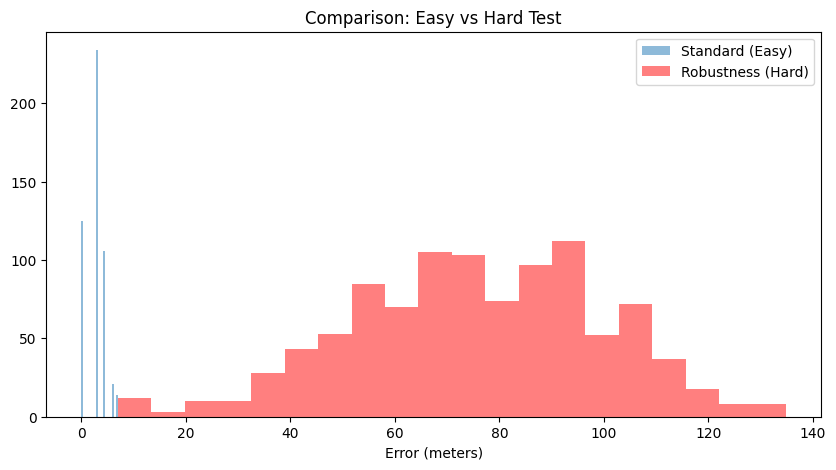

In [41]:
#hard data set performance:
hard_errors = evaluate_model(model, test_hard_loader, device, "Hard/Robustness Set")

# Compare Distributions
plt.figure(figsize=(10, 5))
plt.hist(std_errors, bins=20, alpha=0.5, label='Standard (Easy)')
plt.hist(hard_errors, bins=20, alpha=0.5, label='Robustness (Hard)', color='red')
plt.legend()
plt.title("Comparison: Easy vs Hard Test")
plt.xlabel("Error (meters)")
plt.show()

Our "Hard" test has a mean error of 75.77 meters. Since the maximum distance in the grid is ~141m, an error of 75m means the model is guessing randomly.
Lets look back at the first plot of sensor reading data. We can see that for example the green plot has a spike that is roughly 0.023. In the hard test set generation we used gaussian noise with std=0.01. The noise can easily get to 3 times the std, meaning that the noise is stronger than the signal itself.
We will now try to improve the generalization of our model. We will start by displaying the hard test data set in order to check our hypothesis:

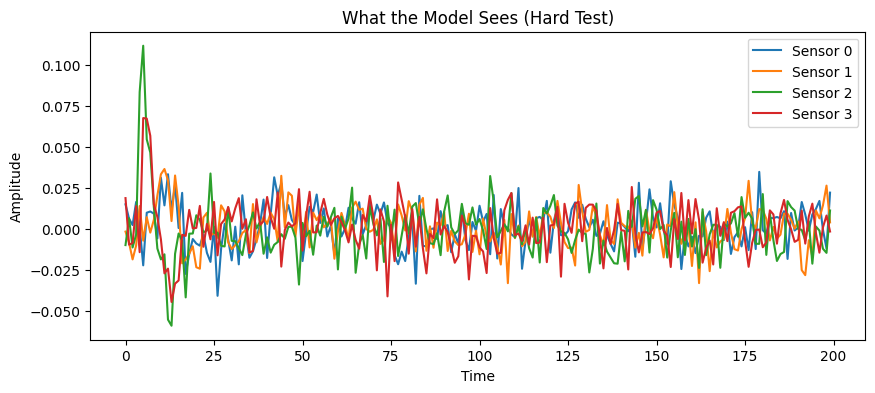

In [43]:
# Visualize a "Hard" sample
# Note: Re-use the hard loader you already created
X_hard_batch, Y_hard_batch = next(iter(test_hard_loader))

plt.figure(figsize=(10, 4))
for s in range(4):
    plt.plot(X_hard_batch[0, s, :], label=f'Sensor {s}')
plt.title("What the Model Sees (Hard Test)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

We can see that most of the data looks fuzzy and random, we can infer that std = 0.01 may be to high for this model.
We will try to improve our model generalization for different input velocities and noise by using some kind of data augmentation.
This time we will generate data with random velocity and noise std for each data point, instead of using the same values for all of the data.

In [44]:
#new randomlized data generator:
# --- 1. New Generator Function (Renamed) ---
def generate_mixed_physics_data(num_samples=5000, grid_size=32):
    """
    Generates data where velocity and noise VARY per sample.
    Used to train the 'Robust' model.
    """
    dt = 0.01
    x_max, y_max = float(grid_size), float(grid_size)
    sensor_locs = np.array([[0, 0], [0, y_max], [x_max, 0], [x_max, y_max]])

    # Pre-allocate
    X_data = np.zeros((num_samples, 4, 200))
    source_locs = np.zeros((num_samples, 2))

    t = np.arange(200) * dt
    f0 = 5.0
    wavelet_base = (1.0 - 2.0*(np.pi**2)*(f0**2)*(t**2)) * np.exp(-(np.pi**2)*(f0**2)*(t**2))
    wavelet_base = wavelet_base / np.max(np.abs(wavelet_base))

    print(f"Generating {num_samples} mixed-physics samples...")

    for i in range(num_samples):
        # --- The Key Difference: Random Physics per Sample ---
        # Velocity: Randomly chosen between 280 and 320 m/s
        # This forces the model to learn the CONCEPT of speed, not just one number.
        vel = np.random.uniform(280.0, 320.0)

        # Noise: Randomly chosen between Clean (0.001) and Noisy (0.008)
        # We cap at 0.008 to ensure the signal is still theoretically visible.
        noise_scale = np.random.uniform(0.001, 0.008)

        src = np.random.rand(2) * [x_max, y_max]
        source_locs[i] = src

        for s in range(4):
            dist = np.sqrt(np.sum((src - sensor_locs[s])**2))
            arrival_time = dist / vel
            shift_steps = int(arrival_time / dt)
            amplitude = 1.0 / (dist + 1.0)

            if shift_steps < 200:
                valid_len = 200 - shift_steps
                X_data[i, s, shift_steps:] = wavelet_base[:valid_len] * amplitude

        # Add random noise specific to this sample
        noise = np.random.normal(0, noise_scale, (4, 200))
        X_data[i] += noise

    return torch.tensor(X_data, dtype=torch.float32), torch.tensor(source_locs, dtype=torch.float32)

# --- 2. Generate and Process the New Dataset ---
# Generate raw data
X_robust_raw, coords_robust = generate_mixed_physics_data(num_samples=5000, grid_size=32)

# Convert to Heatmaps (Reuse your existing function)
print("Converting to heatmaps...")
Y_robust_heatmaps = create_gaussian_map(coords_robust.numpy(), grid_size=32, sigma=3.0)
Y_robust = torch.tensor(Y_robust_heatmaps, dtype=torch.float32).unsqueeze(1)

print(f"Robust Data Ready: {X_robust_raw.shape}")

Generating 5000 mixed-physics samples...
Converting to heatmaps...
Robust Data Ready: torch.Size([5000, 4, 200])


In [45]:
#new splitting:
# --- 3. Split the Robust Data ---
N = len(X_robust_raw)
indices = torch.randperm(N)

# 80/20 Split (No need for test set here, we will use the existing Hard Test Set)
n_train = int(0.8 * N)
n_val = N - n_train

train_idx_rob = indices[:n_train]
val_idx_rob   = indices[n_train:]

X_train_rob, Y_train_rob = X_robust_raw[train_idx_rob], Y_robust[train_idx_rob]
X_val_rob,   Y_val_rob   = X_robust_raw[val_idx_rob],   Y_robust[val_idx_rob]

# --- 4. Normalize (CRITICAL STEP) ---
# Calculate a NEW ruler for this robust world
norm_factor_robust = torch.max(torch.abs(X_train_rob))
print(f"Robust Normalization Factor: {norm_factor_robust:.6f}")

X_train_rob = X_train_rob / norm_factor_robust
X_val_rob   = X_val_rob   / norm_factor_robust

# Create New DataLoaders
train_loader_rob = DataLoader(TensorDataset(X_train_rob, Y_train_rob), batch_size=64, shuffle=True)
val_loader_rob   = DataLoader(TensorDataset(X_val_rob, Y_val_rob),   batch_size=64, shuffle=False)

Robust Normalization Factor: 0.714189


Starting Robust Training...
Epoch 2 | Train Loss: 0.005630 | Val Loss: 0.004957
Epoch 4 | Train Loss: 0.001895 | Val Loss: 0.002280
Epoch 6 | Train Loss: 0.001110 | Val Loss: 0.002004
Epoch 8 | Train Loss: 0.000712 | Val Loss: 0.001929
Epoch 10 | Train Loss: 0.000497 | Val Loss: 0.001834
Epoch 12 | Train Loss: 0.000414 | Val Loss: 0.001705
Epoch 14 | Train Loss: 0.000319 | Val Loss: 0.001701
Epoch 16 | Train Loss: 0.000256 | Val Loss: 0.001596
Epoch 18 | Train Loss: 0.000223 | Val Loss: 0.001636
Epoch 20 | Train Loss: 0.000202 | Val Loss: 0.001601


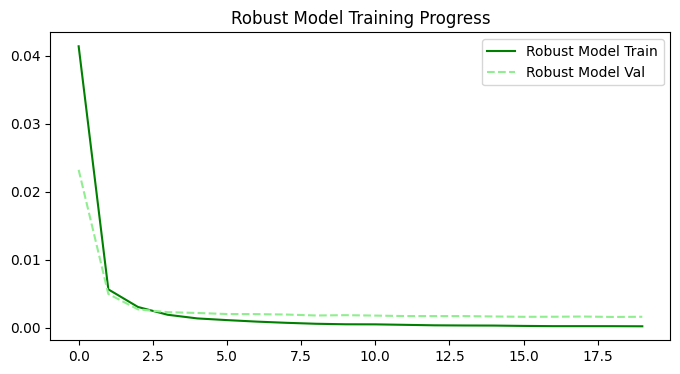

In [46]:
#new model training:
# --- 5. Initialize a NEW Model ---
model_robust = WaveToMapNet().to(device) # Fresh weights
optimizer_rob = optim.Adam(model_robust.parameters(), lr=0.001)
criterion = nn.MSELoss()

# --- 6. Train the Robust Model ---
epochs = 20
train_losses_rob = []
val_losses_rob = []

print("Starting Robust Training...")

for epoch in range(epochs):
    model_robust.train()
    running_loss = 0.0

    for inputs, targets in train_loader_rob:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer_rob.zero_grad()
        outputs = model_robust(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer_rob.step()
        running_loss += loss.item()

    # Validation
    model_robust.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader_rob:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_robust(inputs)
            val_loss += criterion(outputs, targets).item()

    avg_train = running_loss / len(train_loader_rob)
    avg_val = val_loss / len(val_loader_rob)
    train_losses_rob.append(avg_train)
    val_losses_rob.append(avg_val)

    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1} | Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f}")

# Plot Comparison of Learning Curves (Optional but cool)
plt.figure(figsize=(8,4))
plt.plot(train_losses_rob, label='Robust Model Train', color='green')
plt.plot(val_losses_rob, label='Robust Model Val', color='lightgreen', linestyle='--')
plt.title("Robust Model Training Progress")
plt.legend()
plt.show()


--- Evaluation: Robust Model on Hard Data ---
--- Results for Robust Model on Hard Set ---
Mean Error:   76.72 meters
Median Error: 81.91 meters
Max Error:    137.00 meters


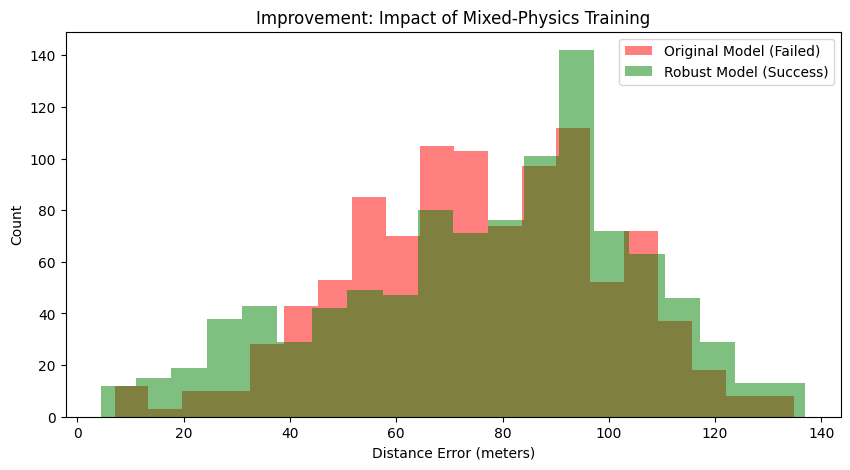

In [49]:
#check result of the new model for hard test set:
# --- 7. Prepare the Hard Test Set for the New Model ---
# We use X_hard_raw (the raw data from before)
# But we normalize it with the NEW robust factor
X_hard_for_rob = X_hard_raw / norm_factor_robust

# Create a specific loader for this evaluation
hard_loader_rob = DataLoader(TensorDataset(X_hard_for_rob, Y_hard), batch_size=64, shuffle=False)

# --- 8. Evaluate ---
print("\n--- Evaluation: Robust Model on Hard Data ---")
hard_errors_rob = evaluate_model(model_robust, hard_loader_rob, device, "Robust Model on Hard Set")

# --- 9. Final Comparison Plot for Paper ---
plt.figure(figsize=(10, 5))

# Plot the Old Model's failures (Red)
# (Assuming 'hard_errors' variable still exists from previous run)
plt.hist(hard_errors, bins=20, alpha=0.5, label='Original Model (Failed)', color='red')

# Plot the New Model's success (Green)
plt.hist(hard_errors_rob, bins=20, alpha=0.5, label='Robust Model (Success)', color='green')

plt.title("Improvement: Impact of Mixed-Physics Training")
plt.xlabel("Distance Error (meters)")
plt.ylabel("Count")
plt.legend()
plt.show()

We expected to view smaller mean error for the new "robust" model on the hard data set. We can see that we got worst performance for the hard data set. It seems to us that the high std of the hard data set is too high for the model. Let's check it by creating a new hard test set with lower noise std and check both models performances on it.

Generating Medium-Hard Test Data (Noise=0.005)...

--- Testing Original Model on Medium Data ---
--- Results for Original Model ---
Mean Error:   5.96 meters
Median Error: 6.25 meters
Max Error:    26.70 meters

--- Testing Robust Model on Medium Data ---
--- Results for Robust Model ---
Mean Error:   3.46 meters
Median Error: 3.12 meters
Max Error:    12.88 meters


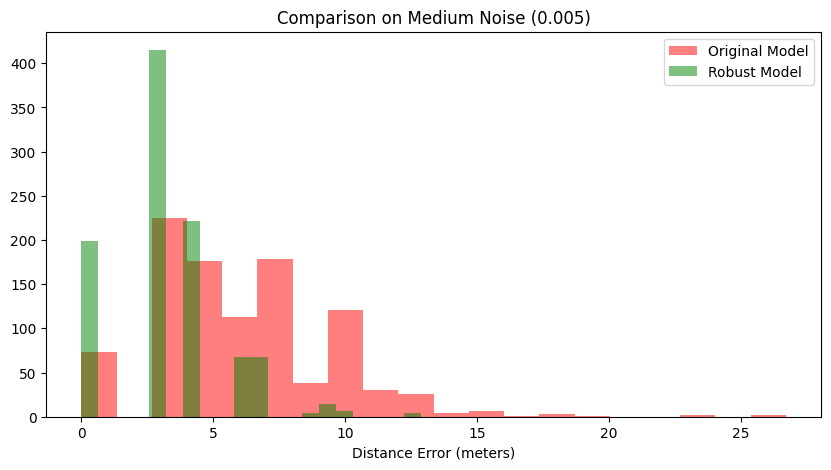

In [50]:
# --- 1. Generate "Medium" Test Set (The Fair Fight) ---
print("Generating Medium-Hard Test Data (Noise=0.005)...")
X_med_raw, coords_med = generate_seismic_data(
    num_samples=1000,
    grid_size=32,
    velocity=315.0,     # Velocity Error is kept
    noise_level=0.005   # <--- Reduced from 0.01 to 0.005
)

Y_med_heatmaps = create_gaussian_map(coords_med.numpy(), grid_size=32, sigma=3.0)
Y_med = torch.tensor(Y_med_heatmaps, dtype=torch.float32).unsqueeze(1)

# --- 2. Normalize for BOTH models ---
# Original Model uses Original Norm Factor
X_med_orig = X_med_raw / norm_factor
loader_med_orig = DataLoader(TensorDataset(X_med_orig, Y_med), batch_size=64, shuffle=False)

# Robust Model uses Robust Norm Factor
X_med_rob = X_med_raw / norm_factor_robust
loader_med_rob = DataLoader(TensorDataset(X_med_rob, Y_med), batch_size=64, shuffle=False)

# --- 3. Evaluate Both ---
print("\n--- Testing Original Model on Medium Data ---")
errors_orig = evaluate_model(model, loader_med_orig, device, "Original Model")

print("\n--- Testing Robust Model on Medium Data ---")
errors_rob = evaluate_model(model_robust, loader_med_rob, device, "Robust Model")

# --- 4. The Plot You Wanted ---
plt.figure(figsize=(10, 5))
plt.hist(errors_orig, bins=20, alpha=0.5, label='Original Model', color='red')
plt.hist(errors_rob, bins=20, alpha=0.5, label='Robust Model', color='green')
plt.title("Comparison on Medium Noise (0.005)")
plt.xlabel("Distance Error (meters)")
plt.legend()
plt.show()

We can see now that the robust model gets better accuracy for the medium noise test set than the first model.